## RNN (Recurrent Neural Networks)

In [1]:
import numpy as np
import pandas as pd

In [2]:
np.__version__

'1.23.5'

### NumPy 實作演算法

In [47]:
# numpy RNN 實作
'''
一個簡單RNN的pseudo-code:
state_t = 0 # 這是某一個"時間步(timestep)"的內部狀態(state)
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t # 前一個處理過的輸出(output)變成新的狀態(state)
'''
timesteps = 100  # 輸入序列中的時間步數
input_features = 32  # 輸入特徵空間的維度
output_features = 64  # 輸出特徵空間的維度

# 這是我們的輸入數據 (建立假資料)
inputs = np.random.random((timesteps, input_features))

# 這是我們的“初始狀態”：一個全零向量
state_t = np.zeros((output_features,))

# 創建隨機權重矩陣
W = np.random.random((input_features, output_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    # 我們將輸入與當前狀態（即前一個輸出）組合以獲得當前輸出。
    output_t = np.tanh(np.dot(input_t, W) + np.dot(state_t, U) + b)
    
    # 我們將此輸出存儲在一個列表中。
    successive_outputs.append(output_t)
    
    # 我們更新下一個時間步的網絡“狀態”
    state_t = output_t

# 最終輸出是2D張量(timesteps, output_features)
final_output_sequence = np.vstack(successive_outputs)



## Keras 套件實作

### 單層 RNN

In [56]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
keras.__version__

"""
跟上述Numpy的RNN函式有一些些的不同： SimpleRNN像所有其他Keras神經層一樣，
它會批次地處理序列(batches of sequences)資料,而不是像我們的Numpy示例中的單個序列。 
這意味著它需要的張量結構形狀(batch_size,timesteps,input_features)的輸入，而不是(timesteps, input_features)。

像Keras中的所有其它的循環神經層(recurrent layers)一樣，SimpleRNN可以用兩種不同的模式來運行：

它可以返回每個時間步的連續輸出的全部序列（一個形狀為(batch_size，timesteps，output_features)的3D張量）
或者它 可以僅返回每個輸入序列的最後一個輸出（一個形狀為(batch_size，output_features)的2D張量）。
這兩種模式由return_sequences構造函數參數控制。
"""
# 引入序列模型 (模型物件實體化)
model = Sequential() 

# 10000 token, 每筆資料32維
model.add(Embedding(10000, 32)) 

# return_sequences預設為False, 返回最後輸出
model.add(SimpleRNN(32)) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### 多層 RNN

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
keras.__version__


model = Sequential()
# 10000 token, 每筆資料32維
model.add(Embedding(10000, 32))

# 建立三層RNN, 並企圖輸出中間的隱藏層結果
model.add(SimpleRNN(32, return_sequences=True)) # 把return_sequences設為True
model.add(SimpleRNN(32, return_sequences=True)) # 把return_sequences設為True
model.add(SimpleRNN(32, return_sequences=True)) # 把return_sequences設為True
model.add(SimpleRNN(32))  # 只有最後的RNN層只需要最後的output, 因此不必特別去設置"return_sequences"

model.summary()

## RNN 處理 IMDB 分類問題

### 文本資料預處理

In [61]:
from keras.datasets import imdb
from keras_preprocessing import sequence

max_features = 10000  # 要考慮作為特徵的語詞數量
maxlen = 500  # 當句子的長度超過500個語詞的部份,就把它刪除掉

# 載入IMDB的資料
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

# 如果長度不夠的話就補空的
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


### 建立模型

In [62]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen)) # 取 10000 特徵語詞數量, 鑲嵌32維
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128, # 每128筆評論 調一次參數
                    validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 20s 118ms/step - loss: 0.5806 - acc: 0.6969 - val_loss: 0.5288 - val_acc: 0.7360
Epoch 2/10
157/157 [==============================] - 20s 129ms/step - loss: 0.3642 - acc: 0.8539 - val_loss: 0.3685 - val_acc: 0.8508
Epoch 3/10
157/157 [======================

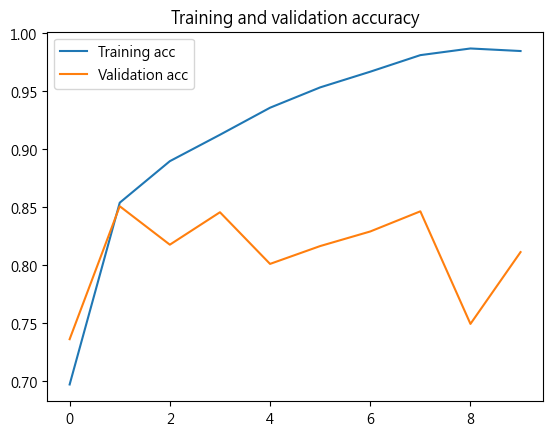

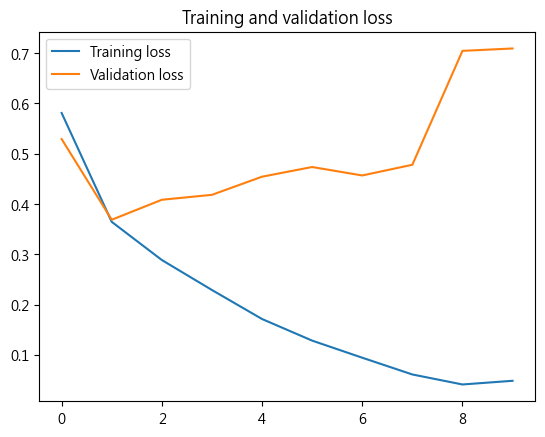

In [63]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 預測結果輸出

In [65]:
# Evaluate the model on the test data
score, acc = model.evaluate(input_test, y_test, verbose=0)
print("Test accuracy:", acc)

# Make predictions on the test data
predictions = model.predict(input_test)

# Since model's output is a probability, you can round the values to get binary predictions (0 or 1)
binary_predictions = [1 if p > 0.5 else 0 for p in predictions]

# Print some sample predictions
print("Sample Predictions:")

# Check top 10 data
for i in range(10):
    print("Actual:", y_test[i], "Predicted:", binary_predictions[i])

Test accuracy: 0.8131999969482422
782/782 [==============================] - 16s 20ms/step
Sample Predictions:
Actual: 0 Predicted: 0
Actual: 1 Predicted: 1
Actual: 1 Predicted: 1
Actual: 0 Predicted: 0
Actual: 1 Predicted: 1
Actual: 1 Predicted: 1
Actual: 1 Predicted: 1
Actual: 0 Predicted: 0
Actual: 0 Predicted: 1
Actual: 1 Predicted: 1
